In [1]:
import numpy as np
import math
import astropy.io.fits as fits
from astropy import stats
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from numba import njit

import spiceypy as spice
import hstprojimage as hst
from TScmap import TScmap
%matplotlib inline

In [2]:
spice.furnsh('kernel/cassMetaK.txt')

filename = 'data/red/2014/006_v06/jup_14-006-02-35-18_0030_v06_stis_f25srf2_flatproj.fits'
ext = 0
hext = 1
with fits.open(filename) as hdul:
    image = hdul[ext].data # .astype(np.float32)
    h = hdul[hext].header

# HST data
moon = 'EUROPA'
h = hst.HSTProjImage(filename)
h.readHSTFile()
h.MOON = moon
IMG = h.image

OBS DATE 2014-01-06T02:35:18


(1000, 1000)


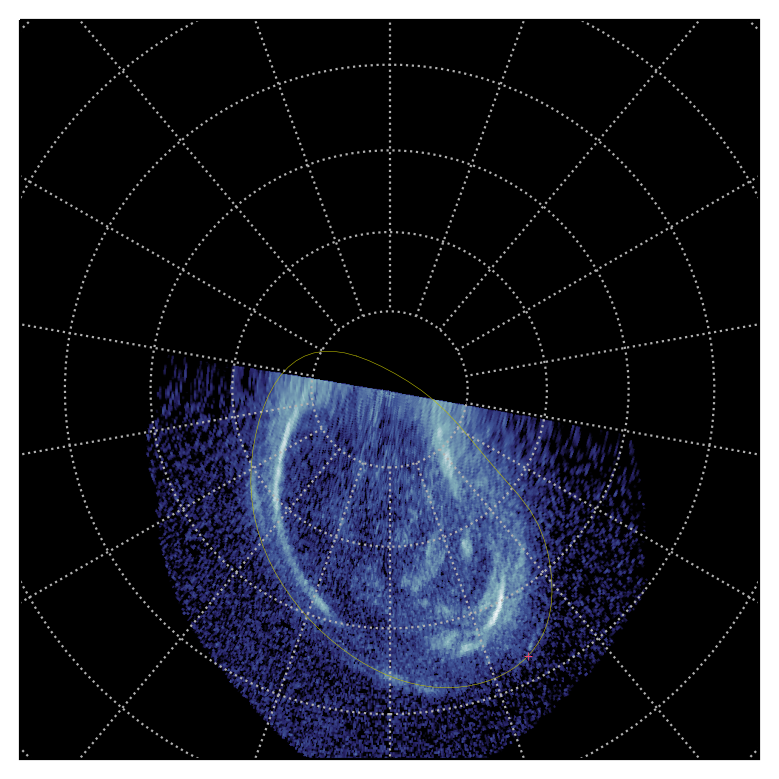

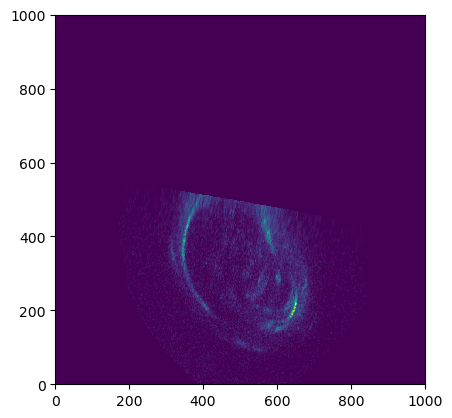

In [3]:
extdeg = 45.0
fig, ax = plt.subplots(dpi=200)
ax, dimage, gl = h.tvPolar(ax, vmin=10, vmax=2000,
                  draw_labels=False, refmainoval=False,
                  satovals=['eu'],
                  reflon=None,
                  # reflon=h.alm.cml,
                  ext=extdeg,
                  )

print(dimage.shape)
Npx = dimage.shape[0]
dimage = dimage[:,::-1]
fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.pcolormesh(dimage)
plt.show()

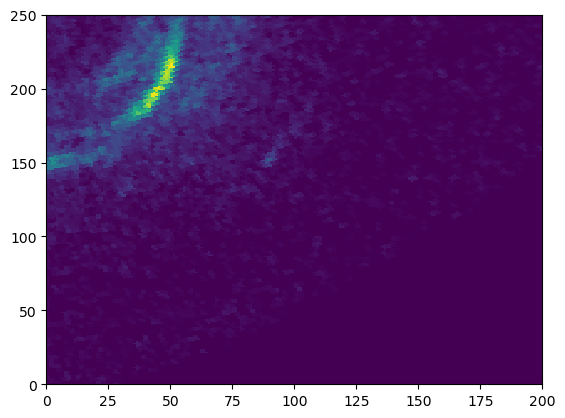

In [4]:
x0, x1 = 600, 800
y0, y1 = 0, 250
img = dimage[y0:y1,x0:x1]
fig, ax = plt.subplots(dpi=100)
ax.pcolormesh(img)
plt.show()

開口測光 (Aperture Photometry)

In [5]:
mean = np.average(img)
median = np.median(img)
std = np.std(img)
print('STD', std)
thres = 1.2*std
daofind = DAOStarFinder(fwhm=2.0, threshold=thres)  
# https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html
# DAOStarFinderのfluxの定義 ... stdのfactor倍
sources = daofind(img)  
print(sources)

STD 148.40918
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 29.796068071218386 ...  1.170880675315857  -0.17128159572448953
  2 1.0459864128155354 ...  2.230254650115967   -0.8708861338829428
  3  5.358018557329415 ... 1.3547718524932861   -0.3296654122959749
  4  58.15733014218266 ... 1.2572107315063477  -0.24852019870926192
  5 17.111891734773103 ... 1.3199609518051147  -0.30140270932825436
  6 45.034983958826786 ... 1.1406716108322144  -0.14290158227541522
  7  88.63540305316786 ... 1.4107416868209839   -0.3736187493782147
  8  1.682038078468359 ...  2.455096483230591   -0.9751714105072152
  9  7.486319540363095 ... 1.4581048488616943   -0.4094718854776285
 10  90.93870842474168 ... 1.0224813222885132 -0.024138458688373766
...                ... ...                ...                   ...
 44  39.56293410304895 ... 1.2548091411590576   -0.2464441845727092
 45  72.46565867082855 ... 1.22145

=== JRM33 Estimation ===
Sys3,lat 152.62117521949583 52.78842080905891
Wlong [deg] 152.62117521949583
Lat [deg] 52.78842080905891
extdeg 45.0
ftps3lat 52.78842080905891
=== The spot ===
Nearest [px]: 6 [688.63540305 151.91041197]
Number of pixels [px]:  25
Brightness peak [kR]:  486.1923828125
Brightness flux [kR]:  251.24041979047468
Wlong [deg] 151.54601651574762
Lat [deg] 53.68228541345377


(<matplotlib.patches.Circle at 0x280d2d600>,)

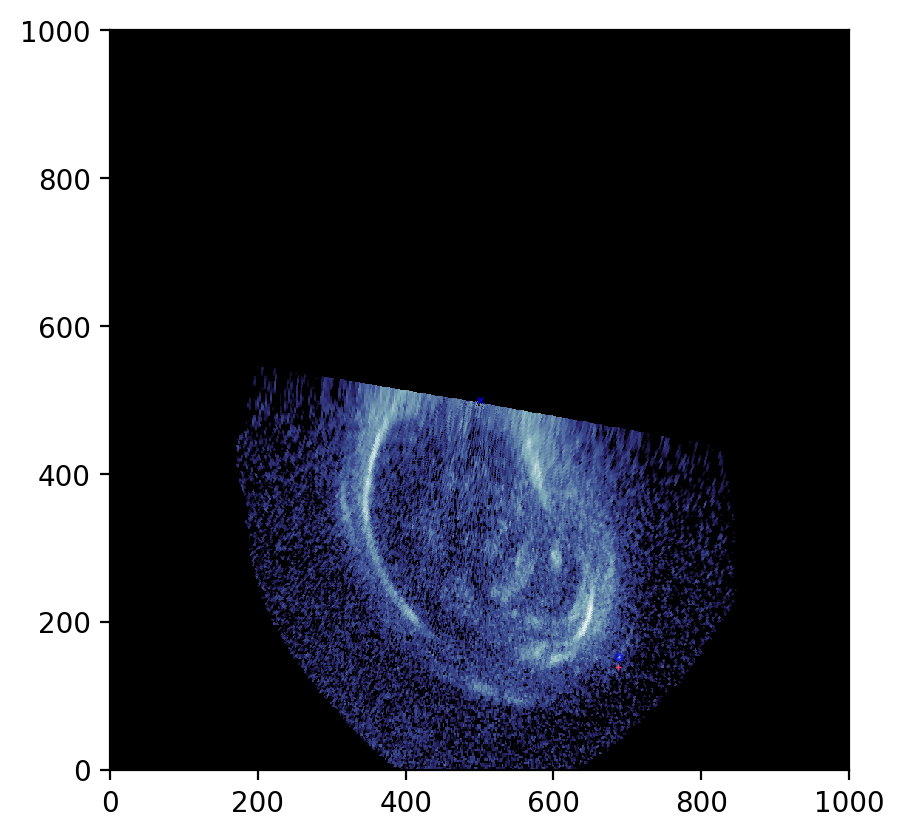

In [8]:
ftps3wlon = h.s3wlon_lin            # [deg]
ftps3lat = h.s3lat_lin              # [deg]
print('=== JRM33 Estimation ===')
print('Sys3,lat', ftps3wlon, ftps3lat)
print('Wlong [deg]', ftps3wlon)
print('Lat [deg]', ftps3lat)

ftpelon = 360-(ftps3wlon-90)        # [deg]
ftpcolat = 90-ftps3lat              # [deg]
ftpR = ftpcolat*(Npx/(2*extdeg))    # [px]
ftpR = (Npx/2)*(math.tan(math.radians(ftpcolat/2))/math.tan(math.radians((90-extdeg)/2)))     # [px]
print('extdeg', extdeg)
print('ftps3lat', ftps3lat)
ftpX = ftpR*np.cos(np.radians(ftpelon))         # [px]
ftpY = ftpR*np.sin(np.radians(ftpelon))         # [px]
ftpX += Npx/2
ftpY += Npx/2
# print(ftpcolat, ftpR, ftpX, ftpY)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  # [px]
positions[:,0] += x0    # [px]
positions[:,1] += y0    # [px]

posarg0 = np.argmin(np.absolute((positions[:,0]-ftpX)**2 + (positions[:,1]-ftpY)**2))
print('=== The spot ===')
print('Nearest [px]:', posarg0, positions[posarg0,:])
print('Number of pixels [px]: ', sources['npix'][posarg0])
print('Brightness peak [kR]: ', sources['peak'][posarg0])
print('Brightness flux [kR]: ', sources['flux'][posarg0]*thres)

posX = positions[posarg0,0]-Npx/2
posY = positions[posarg0,1]-Npx/2
posR = math.sqrt(posX**2 + posY**2)             # [px]
poslat = posR*(2*extdeg/Npx)
poslat = math.degrees(2*math.atan2(posR*math.tan(0.5*math.radians(90-extdeg)), Npx/2))
postheta = math.atan2(posY,posX)-0.5*np.pi
# print('theta [deg]', math.degrees(postheta))
print('Wlong [deg]', -math.degrees(postheta))
print('Lat [deg]', 90-poslat)

apertures = CircularAperture(positions[posarg0,:], r=4.)
fig, ax = plt.subplots(dpi=200)
ax.set_aspect('equal')
# ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(), vmin=median-5*std, vmax=median+5*std, zorder=0.1)
ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
ax.plot(ftpX, ftpY,
        markersize=2, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=0.5, zorder=1)
ax.plot(Npx/2, Npx/2,
        markersize=2, marker='x', markerfacecolor='blue',
        markeredgecolor='blue', markeredgewidth=0.5, zorder=1)
apertures.plot(color='blue', lw=1.0, alpha=0.6)
# circle = plt.Circle((Npx/2,Npx/2), ftpR, ec='r', fill=False)
# ax.add_patch(circle)